This explainer notebook is made as a part of the final exam project for the course 02805, Social graphs and interactions.
The results of the explainer notebook are also displayed on the [webpage](https://artists-collaborations-network.netlify.app/).
Several other notebooks and files were used to construct the explainer notebook. 
These can be found on [GitHub](https://github.com/andreas-kaae/socialgraphs2020_artists_collaborations_network), due to data limitations on github. To access the data a DTU login is needed.


The authors are:  
*Xiao He - s210305*  
*YiFan Liu - s210307*  
<br>

**Collaboration table**  
All team members have contributed equally to the project and know and understand every aspect of the project.
However, accordingly to the description of the project a person needs to be responsible for every aspect of the project.
The table below is thus constructed.  



| Task                                    	| Main responsible 	|
|-----------------------------------------	|:----------------:	|
| Scrapping Wikipedia API                  	|      Xiao     	|
| Building the network                    	|      Xiao     	|
| Network analysis                        	|      Xiao      	|
| Word Clouds                           	|      YiFan    	|
| Text analysis                           	|      Xiao     	|
| Webpage content                	        |      YiFan        |
| Setup and desing of webpage             	|      YiFan      	|

In [1]:
import re
import pandas as pd
import urllib.request
import json
import string
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from urllib.request import urlopen
from fa2 import ForceAtlas2
import re
import nltk
import io
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
from community import community_louvain
import ast
import urllib.request
from nltk import word_tokenize, FreqDist
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from urllib.request import urlopen
import json
from fa2 import ForceAtlas2
import powerlaw
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.colors as colors  
from PIL import Image
from collections import Counter
import os
import string
from textblob import TextBlob # for sentiment analysis
%matplotlib inline

# 1 Motivation

In [70]:
from IPython.display import YouTubeVideo
YouTubeVideo("ca178i3evX8&t", width = 800, height = 450)

## 1.1 Dataset

The first dataset we used is from wikipedia api, and its size is 17Mb. We got 730 characters and 121 monster nodes. It may increase in our follow-up work.

- Each character has different attributes, such as race, profession, nationality, etc.

- Monsters have eleven categories, such as Elementa, Hybrids, and their respective locations and weaknesses. 

- The network consists with 787 nodes and 1514 edges.

The second dataset is the script of TV series:first season of “the Witcher”, which contians all the dialog between characters. 

## 1.2 Our goal
We want to show the **complex background** and story of this world through the analysis of each character.

In [168]:
import requests

S = requests.Session()

URL = "https://witcher.fandom.com/api.php?"

PARAMS = {
    "action": "query",
    "format": "json",
    "list": "categorymembers",
    "cmtitle":"Category:Hearts_of_Stone_characters",
    "cmlimit":"500",
    "cmprop":"title",
    "continue":"||"
}

R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES = DATA["query"]

#for page in PAGES:
#    print(page["title"])

In [ ]:
idx_continue = DATA['continue']
PARAMS.update(DATA['continue'])
R = S.get(url=URL, params=PARAMS)
DATA = R.json()

PAGES_left = DATA["query"]

In [115]:
characters=PAGES["categorymembers"]+PAGES_left["categorymembers"]

In [171]:
characters_list=[x['title'] for x in characters if x['ns']==0]

In [173]:
del(characters_list[0])

In [137]:
def change_name(name):
    return name.replace(' ','_')

In [174]:
df = pd.DataFrame(list(map(change_name,characters_list)),columns=['Name'])
df =df.drop_duplicates(subset='Name',keep='first')
df.to_csv("Hearts_of_Stone_characters.csv",encoding='utf-8')

In [127]:
# Extract character list
baseurl = "https://witcher.fandom.com/api.php?"
action = "action=query"
title_1 = "titles=Norbert_von_Esteken"
#title_1 = "titles=%s"%characters_list[1]
content = "prop=revisions&rvprop=content&rvslots=*"
dataformat = "format=json"

query_1 = "%s%s&%s&%s&%s" %(baseurl, title_1, action, content, dataformat)

wikiresponse_1 = urlopen(query_1)
wikisource_1 = wikiresponse_1.read().decode('utf-8')
wikijson_1 = json.loads(wikisource_1)


In [165]:
df.to_csv("Blood_and_Wine_characters.csv",encoding='utf-8')

In [182]:
df1 = pd.read_csv('Blood_and_Wine_characters.csv')
df2 = pd.read_csv('Hearts_of_Stone_characters.csv')
df3 = pd.read_csv('The_Witcher_3_characters.csv')

In [185]:
df = pd.concat([df1, df2, df3])

In [189]:
df= df.reset_index(drop=True)
df.to_csv("characters.csv",encoding='utf-8')

# 2 Basic stats

In [2]:
G = nx.read_gpickle("graph.gpickle")

100%|██████████| 100/100 [00:01<00:00, 56.78it/s]

BarnesHut Approximation  took  0.20  seconds
Repulsion forces  took  1.50  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


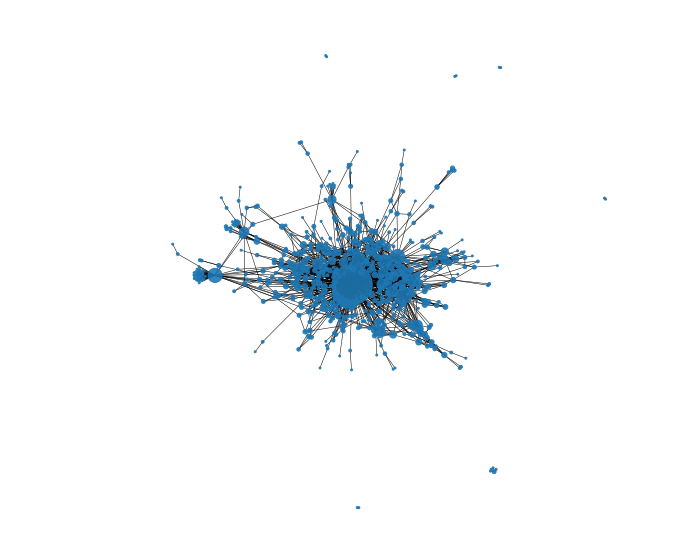

In [9]:
node_size = [i*4 for i in dict(G.degree).values()]
plt.figure(figsize=(12,10))

forceatlas2 = ForceAtlas2()
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

nx.draw_networkx_nodes(G, positions, node_size=node_size, alpha=0.9)
nx.draw_networkx_edges(G, positions, alpha=1, width=0.5)

plt.axis('off')
plt.show()

100%|██████████| 200/200 [00:04<00:00, 43.54it/s]


BarnesHut Approximation  took  0.43  seconds
Repulsion forces  took  4.04  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.03  seconds


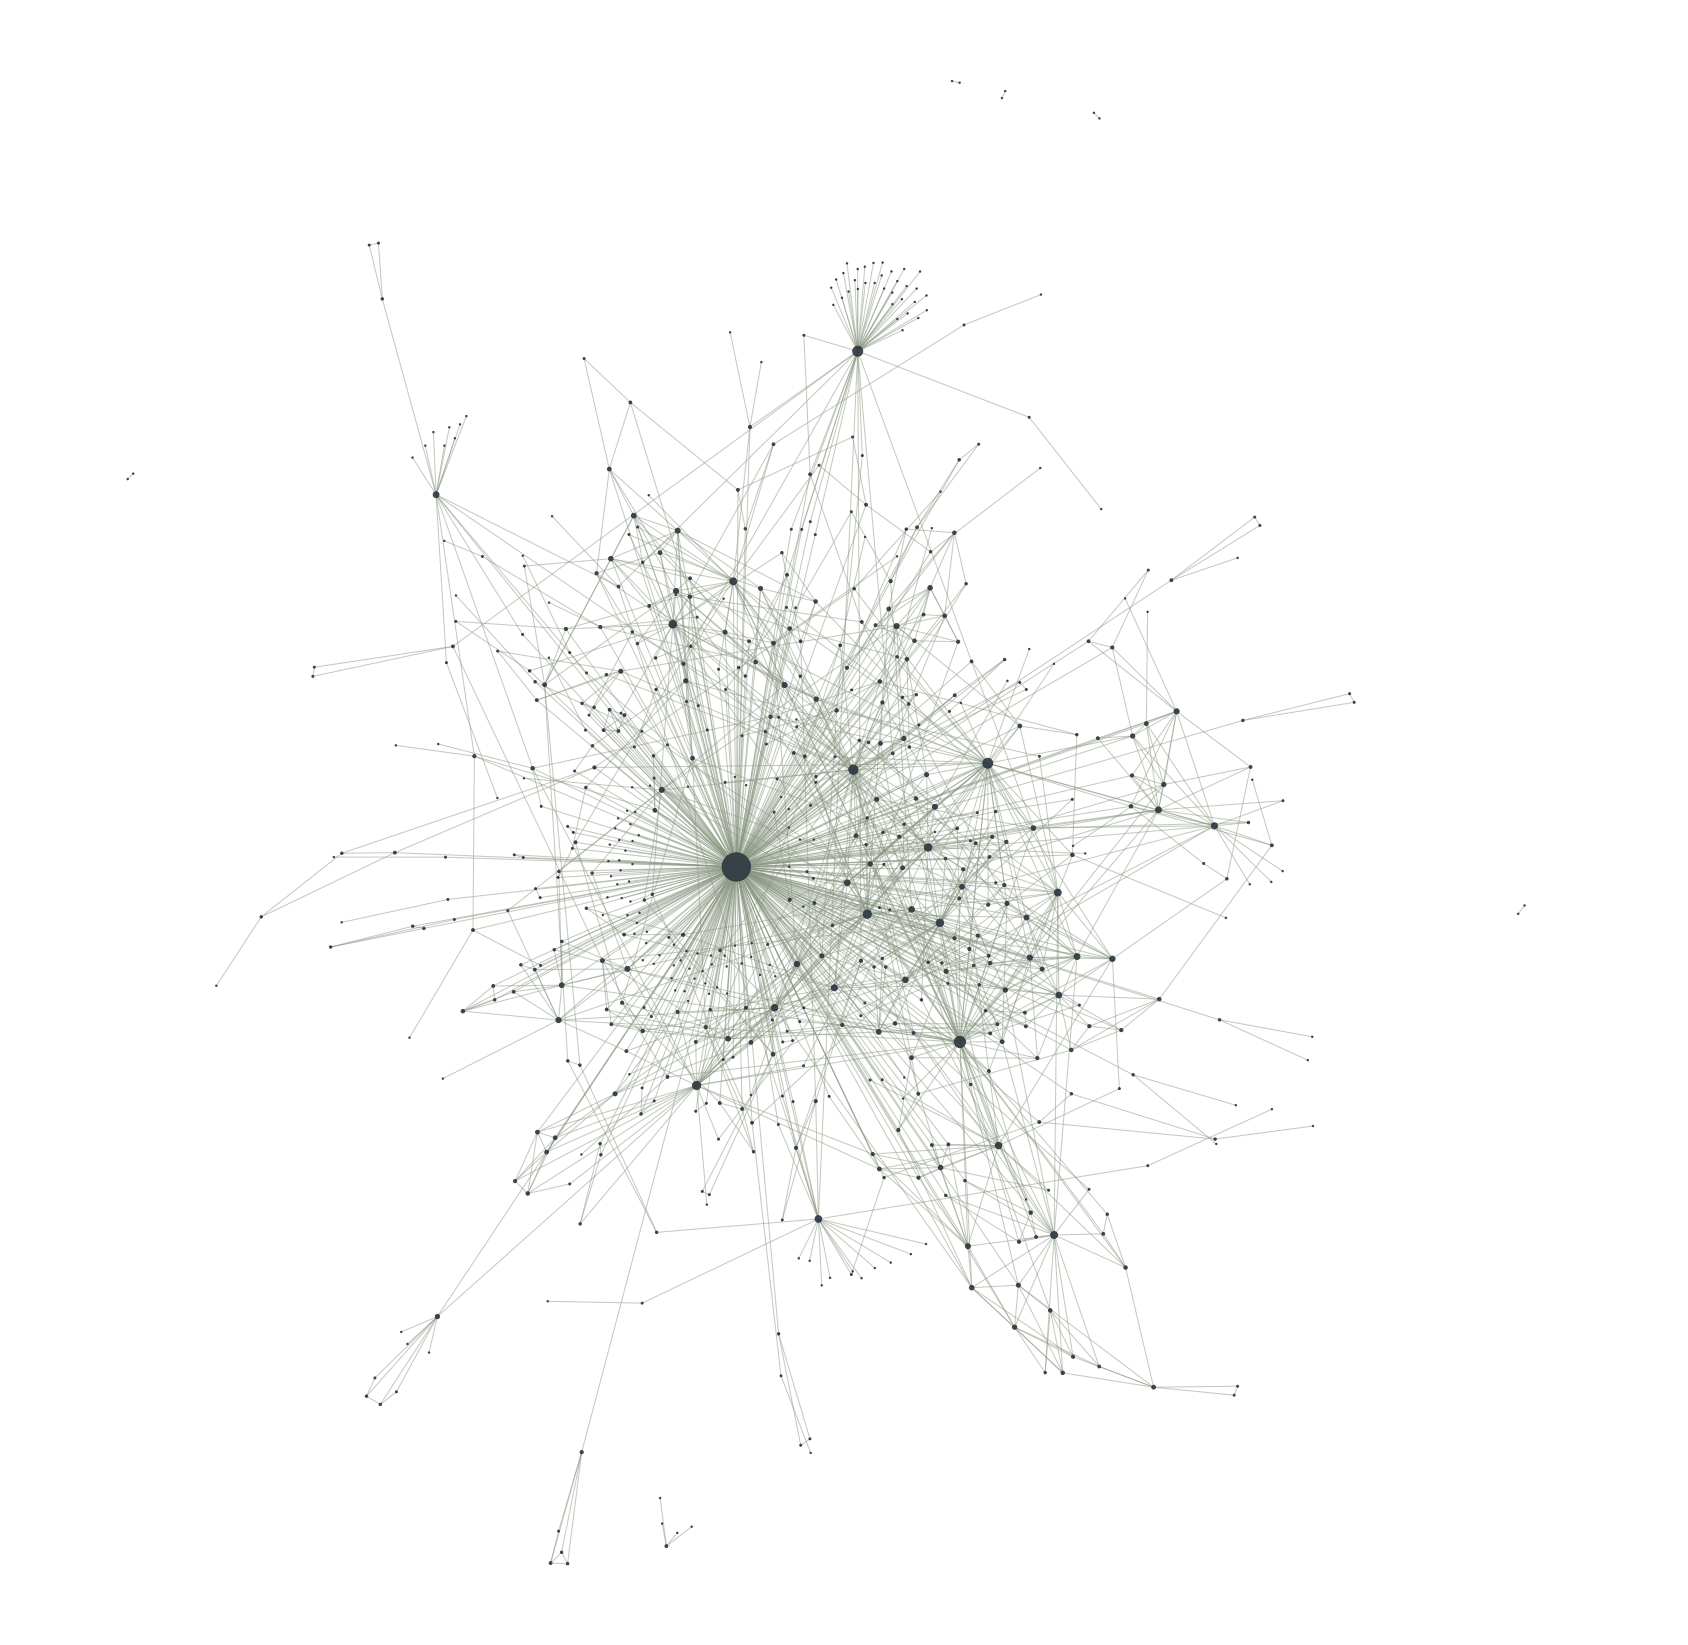

In [39]:
# Firstly, making an undirected version of the network so the plotting is better to work with
G_undirected = G.to_undirected()
      
# Making a list of sizes for each node, based on the node's degree
d = dict(G_undirected.degree)
sizes = [2*v for v in d.values()]

# Declaring Force Atlas 2 parameters
forceatlas2 = ForceAtlas2(outboundAttractionDistribution = False,
                          edgeWeightInfluence = 0.5,
                          jitterTolerance = 0.2,
                          barnesHutOptimize = True,
                          barnesHutTheta = 0.6,
                          scalingRatio = 2.0,
                          strongGravityMode = True,
                          gravity = 1.0)

# Making the graph
positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos = None, iterations = 200)
nx.draw_networkx_nodes(G_undirected, positions, node_size = sizes, alpha = 0.9, node_color = '#2e3842')
nx.draw_networkx_edges(G_undirected, positions, edge_color = "#87947f", alpha = 0.5)
plt.rcParams["figure.figsize"] = [30,30]
plt.axis('off')
plt.show()

In [6]:
G.number_of_edges()

1514

In [7]:
G.number_of_nodes()

787

In [5]:
G = nx.read_gpickle("graph.gpickle")

In [6]:
df = pd.read_csv('./creatures.csv') 
creatures = df.Name.tolist()

In [33]:
page_path='./creature_description/'
for node in creatures:
    with open(page_path+node+'.txt', 'r',encoding='utf-8') as f:
        node_description = f.read()
    # Find Class
    pattern1 = "Class = \[\[(.*?)\]\]"
    list1=re.findall(pattern1, node_description)
    if list1:
        G.add_node(node, Class = list1[0])
    # Find Race
    pattern2 = "Race = \[\[(.*?)\]\]"
    list2=re.findall(pattern2, node_description)
    if list2:
        G.add_node(node, race = list2[0])
    # Find Profession
    pattern3 = "Profession = \[\[(.*?)\]\]"
    list3=re.findall(pattern3, node_description)
    if list3:
        G.add_node(node, Profession = list3[0])
    # Find Nationality
    pattern4 = "Nationality = \{\{(.*?)\}\}"
    list4=re.findall(pattern4, node_description)
    if list4:
        G.add_node(node, Nationality = list4[0])
    
    

In [36]:
nx.write_gpickle(G, "graph_with_attributes.gpickle")

In [44]:
df.index[df['Name'] == node].tolist()

[786]

In [51]:
df1 = pd.concat([df, pd.DataFrame(columns=['Race']), pd.DataFrame(columns=['Profession']), pd.DataFrame(columns=['Nationality'])], sort=False)

In [82]:

for node in creatures:
    index = df.index[df['Name'] == node].tolist()
    with open(page_path+node+'.txt', 'r',encoding='utf-8') as f:
        node_description = f.read()
    # Find Class, for bestiary, it is included in Race
    pattern1 = "Class = \[\[(.*?)\]\]"
    list1=re.findall(pattern1, node_description)
    if list1:
        df1.loc[index, 'Race'] = list1[0]
    # Find Race
    pattern2 = "Race = \[\[(.*?)\]\]"
    list2=re.findall(pattern2, node_description)
    if list2:
        df1.loc[index, 'Race'] = list2[0]
    # Find Profession
    pattern3 = "Profession = \[\[(.*?)\]\]"
    list3=re.findall(pattern3, node_description)
    if list3:
        df1.loc[index, 'Profession'] = list3[0]
    # Find Nationality
    pattern4 = "Nationality = \{\{(.*?)\}\}"
    list4=re.findall(pattern4, node_description)
    if list4:
        df1.loc[index, 'Nationality'] = list4[0]
    # Find Occurence,for bestiary, it is included in Nationality
    pattern5 = "Occurrence = \[\[(.*?)\]\]"
    list5=re.findall(pattern5, node_description)
    if list5:
        df1.loc[index, 'Nationality'] = list5[0]

In [83]:
df1.to_csv("creatures_with_attributes.csv",encoding='utf-8')

In [7]:
df = pd.read_csv('./creatures_with_attributes.csv',encoding='utf-8') 

In [4]:
df = df1

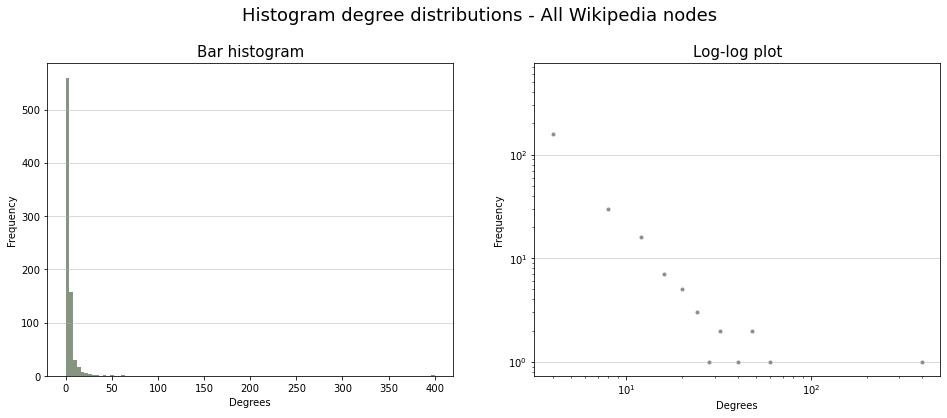

The minimum degree is 0
The maximum degree is 400


In [90]:
# Extracting the degree for each node
degrees = [G.degree(n) for n in G.nodes()]
degree_list = np.array(list(dict(G.degree).values())) # Extracting values from degree dictionary
max_degree = max(degree_list)
min_degree = min(degree_list)

# Using numpy.histogram to put the whole degree list into bins based on the created list above for the log-log plot
hist = np.histogram(degree_list, bins = 100)

# Constructing a figure of histogram degree distributions
figure1, axes1 = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
figure1.suptitle('Histogram degree distributions - All Wikipedia nodes', fontsize = 18)

axes1[0].hist(degrees, bins = 100, color = '#87947f')
axes1[0].set_title('Bar histogram', fontsize = 15)
axes1[0].grid(axis = 'y', alpha = 0.6)
axes1[1].loglog(list(hist[1][:-1]), list(hist[0]), '.', color = '#87947f')
axes1[1].set_title('Log-log plot', fontsize = 15)
axes1[1].grid(axis = 'y', alpha = 0.6)

for i in range(0,2):
    axes1[i].set_xlabel('Degrees')
    axes1[i].set_ylabel('Frequency')

figure1.subplots_adjust(top = 0.85)
plt.show()

print(f'The minimum degree is {min_degree}')
print(f'The maximum degree is {max_degree}')

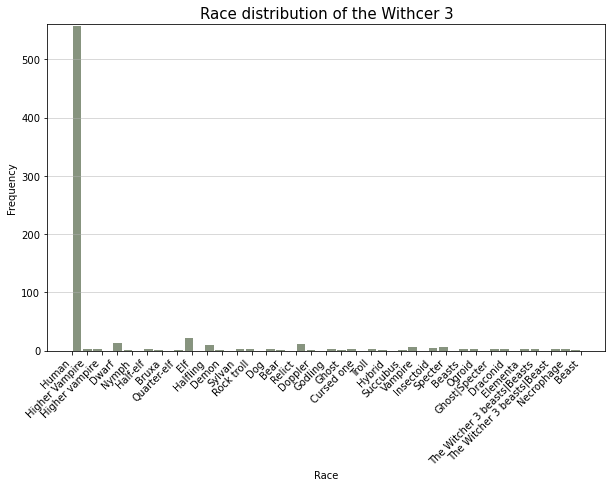

In [118]:
sns.reset_orig()

racelist = [i for i in newDf['Race']]

# Constructing a figure of the birth year distribution
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(x = racelist, bins = 50, color = '#87947f', rwidth = 0.85)
plt.title('Race distribution of the Withcer 3', fontsize = 15)
plt.grid(axis = 'y', alpha = 0.6)
plt.xlabel('Race')
plt.ylabel('Frequency')
maxfreq = n.max()
# Setting a clean upper y-axis limit
plt.xticks(rotation=45, ha='right')
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()


In [119]:
Counter(racelist)

Counter({'Human': 557,
         'Higher Vampire': 2,
         'Higher vampire': 2,
         'Dwarf': 13,
         'Nymph': 1,
         'Half-elf': 2,
         'Bruxa': 1,
         'Quarter-elf': 1,
         'Elf': 21,
         'Halfling': 9,
         'Demon': 1,
         'Sylvan': 2,
         'Rock troll': 3,
         'Dog': 2,
         'Bear': 1,
         'Relict': 11,
         'Doppler': 1,
         'Godling': 2,
         'Ghost': 1,
         'Cursed one': 3,
         'Troll': 2,
         'Hybrid': 1,
         'Succubus': 1,
         'Vampire': 7,
         'Insectoid': 5,
         'Specter': 6,
         'Beasts': 3,
         'Ogroid': 2,
         'Ghost|Specter': 2,
         'Draconid': 3,
         'Elementa': 2,
         'The Witcher 3 beasts|Beasts': 2,
         'The Witcher 3 beasts|Beast': 2,
         'Necrophage': 3,
         'Beast': 1})

In [116]:

Counter(nationlist)


Counter({'Toussaintois': 92,
         'Skelliger': 124,
         'Alban': 10,
         'Lyrian-Rivian': 1,
         'Nilfgaardian': 9,
         'Temerian': 109,
         'Crinfrider': 2,
         'Nazairi': 13,
         'Cintran': 2,
         'Kovirian': 5,
         'Redanian': 106,
         'Malleorean': 1,
         'Ofiri': 7,
         'Maechtian': 1,
         'Aedirnian': 3,
         'Metinnese': 3,
         'Attrean': 4,
         'Povissite': 1,
         'Mahakaman': 4,
         'Cidarian': 1,
         'redanian': 1,
         'Zerrikanian': 1,
         'Novigradian': 13,
         'Velen': 2,
         'Kaedwenian': 3,
         'Novigrad': 1,
         'Creydener': 1,
         'Toussaint': 25,
         'Blood Simple': 1,
         'Land of a Thousand Fables': 7,
         'Dragon Mountains': 1,
         'Dulcinea Windmill': 1,
         'Mont Crane Castle': 1,
         'Seidhe Llygad Amphitheater': 1,
         'Hen Gàidh': 1,
         'Tourney Grounds': 1,
         'Corvo Bianco': 1,
   

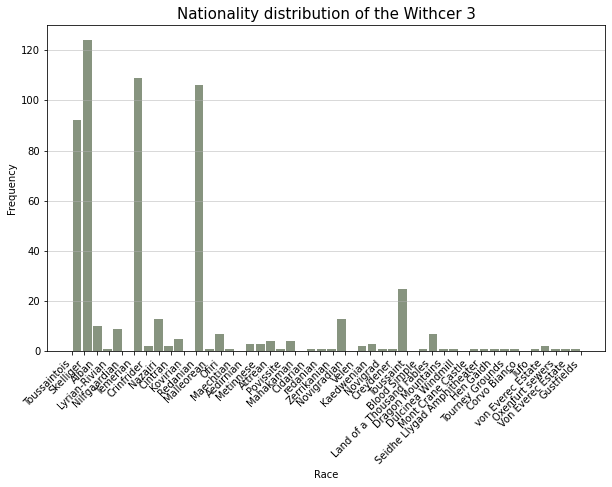

In [117]:

newDF_nation = df.dropna(subset=['Nationality'])
sns.reset_orig()

nationlist = [i for i in newDF_nation['Nationality']]

# Constructing a figure of the birth year distribution
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(x = nationlist, bins = 50, color = '#87947f', rwidth = 0.85)
plt.title('Nationality distribution of the Withcer 3', fontsize = 15)
plt.grid(axis = 'y', alpha = 0.6)
plt.xlabel('Race')
plt.ylabel('Frequency')
maxfreq = n.max()
# Setting a clean upper y-axis limit
plt.xticks(rotation=45, ha='right')
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

In [2]:
df = pd.read_csv('bestiary.csv')
df1 = pd.concat([df, pd.DataFrame(columns=['Race']), pd.DataFrame(columns=['Profession']), pd.DataFrame(columns=['Nationality'])], sort=False)

In [4]:
enemy = df.Name.tolist()
page_path='./creature_description/'
for node in enemy:
    index = df.index[df['Name'] == node].tolist()
    with open(page_path+node+'.txt', 'r',encoding='utf-8') as f:
        node_description = f.read()
    # Find Class, for bestiary, it is included in Race
    pattern1 = "Class = \[\[(.*?)\]\]"
    list1=re.findall(pattern1, node_description)
    if list1:
        df1.loc[index, 'Race'] = list1[0]
    # Find Race
    pattern2 = "Race = \[\[(.*?)\]\]"
    list2=re.findall(pattern2, node_description)
    if list2:
        df1.loc[index, 'Race'] = list2[0]
    # Find Profession
    pattern3 = "Profession = \[\[(.*?)\]\]"
    list3=re.findall(pattern3, node_description)
    if list3:
        df1.loc[index, 'Profession'] = list3[0]
    # Find Nationality
    pattern4 = "Nationality = \{\{(.*?)\}\}"
    list4=re.findall(pattern4, node_description)
    if list4:
        df1.loc[index, 'Nationality'] = list4[0]
    # Find Occurence,for bestiary, it is included in Nationality
    pattern5 = "Occurrence = \[\[(.*?)\]\]"
    list5=re.findall(pattern5, node_description)
    if list5:
        df1.loc[index, 'Nationality'] = list5[0]

In [5]:
df1.head()

,Unnamed: 0,Unnamed: 0.1,Name,Link,Race,Profession,Nationality
0,0.0,0.0,Alp,"['Vampire', 'Vampire_language', 'Common_Speech...",Vampire,NaN,Toussaint
1,1.0,1.0,Alpha_Garkain,"['Vampire', 'Garkain', 'Blood_Simple', 'Moon_d...",Vampire,NaN,Blood Simple
2,2.0,2.0,Arachnomorph,"['Insectoid', 'Aard', 'Axii', 'Insectoid_oil',...",Insectoid,NaN,NaN
3,3.0,3.0,Archespore,"['fear', 'stun', 'Axii', 'pain', 'poison', 'se...",Cursed one,NaN,Toussaint
4,4.0,4.0,Balbina_the_Goose,"['Goose', 'goose', 'Land_of_a_Thousand_Fables'...",NaN,NaN,NaN


In [6]:
df1.to_csv("bestiary_with_attributes.csv",encoding='utf-8')

In [7]:
df = df1

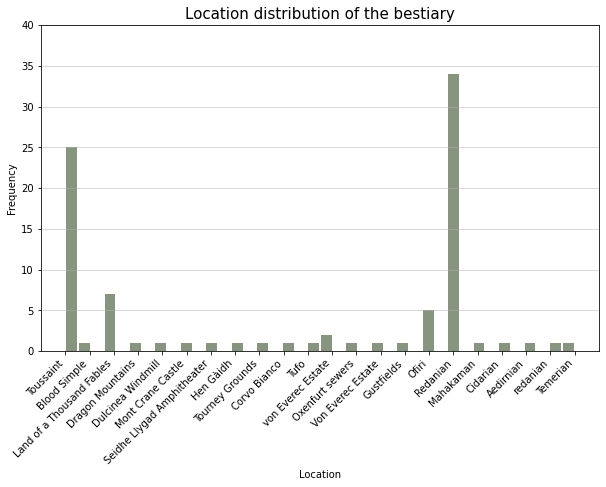

In [11]:
newDF_nation = df.dropna(subset=['Nationality'])
sns.reset_orig()

nationlist = [i for i in newDF_nation['Nationality']]

# Constructing a figure of the birth year distribution
plt.figure(figsize = (10,6))
n, bins, patches = plt.hist(x = nationlist, bins = 40, color = '#87947f', rwidth = 0.85)
plt.title('Location distribution of the bestiary', fontsize = 15)
plt.grid(axis = 'y', alpha = 0.6)
plt.xlabel('Location')
plt.ylabel('Frequency')
maxfreq = n.max()
# Setting a clean upper y-axis limit
plt.xticks(rotation=45, ha='right')
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

# 3 Tools, theory and analysis

**Talk about how you've worked with text, including regular expressions, unicode, etc.**
   
- Regular expressions are used quite a lot, both in this section and the former one. They are mainly used to clean text data and extract Wikipedia links from the Wikipedia pages. 

**Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving. How did you use the tools to understand your dataset?**
   
A few different tools and strategies are used.
- For word clouds, the Louvain Method is used for community detection to split the nodes into different groups according to their races. TF-IDF ranking of words is used to extract the most interesting and frequent ones which appear.Finnally use color mask for their word - clouds.
- For the sentiment analysis. We use NLTK for the wikipedia analysis and Textblob for the dialog analysis. And we cleaned the dialog text by removing punctuation, stopwords, etc. Only top 15 characters in lines are chosen for analysis.

## 3.1 Word Clouds

In [88]:
newDf = df.dropna(subset=['Race'])

In [8]:
# Based on Race
file_list_all = [i+'.txt' for i in creatures]
df['file_name'] = file_list_all
file_list = []
for i in creatures: 
    if df[df['Name']==i].Race.isnull().bool():
        pass
    else:
        file_list.append(i+'.txt')

newDf = df.dropna(subset=['Race'])
        
corpus_root = 'creature_description'
filelists = nltk.corpus.PlaintextCorpusReader(corpus_root, file_list)
Zelda_Text = nltk.Text(filelists.words())

races = newDf['Race'].unique()
race_texts = []  

for r in races:
    file_race = newDf[newDf['Race']==r].file_name
    r_corpus = nltk.corpus.PlaintextCorpusReader(corpus_root, file_race)
    r_Text = nltk.Text(r_corpus.words())
    race_texts.append(r_Text)

def compute_tf(words, doc):
    tf = [doc.count(i)/len(doc) for i in words]
    return tf

def compute_idf(words, docs):
    idf_m = np.empty(shape=(len(docs),len(words)))
    
    for i,d in enumerate(docs):
        if_exist = [1 if i in d else 0 for i in words]
        idf_m[i,:] = if_exist
    
    idf =  np.log(len(docs) / np.sum(idf_m, axis=0))
    
    return idf
    
race_tf = []; common_words = []  

for i, r in enumerate(race_texts):
    fdist = nltk.FreqDist(r)
    most_5 = fdist.most_common(5); words = [i[0] for i in most_5]
    tf = compute_tf(words, r)
    words_tf = list(zip(words, tf))
    race_tf.append(words_tf)
    common_words.append(words)


race_idf = []
for i in common_words: #words = [i[0] for i in most_5]
    idf = compute_idf(i, race_texts)
    race_idf.append(idf)

tf_idfs = []
for r in race_texts:
    words = set(r)
    tf = compute_tf(words, r)
    idf = compute_idf(words, race_texts)
    tf_idf = tf * idf
    tf_idfs.append(tf_idf)

for i, t in enumerate(tf_idfs):
    index = np.argsort(t)[-5:]   #sorted(range(len(t)), key=lambda x: t[x])[-5:]
    content = list(set(race_texts[i]))
    words = [content[n] for n in index]

<img src="siri.png" style="zoom:40%"> 

<img src="Vampire.png" style="zoom:35%"> 

<img src="Dwarf.png" style="zoom:40%"> 

<img src="Elf.png" style="zoom:45%">  

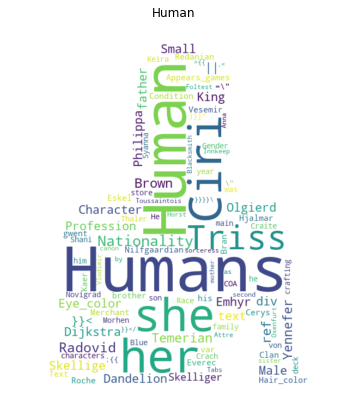

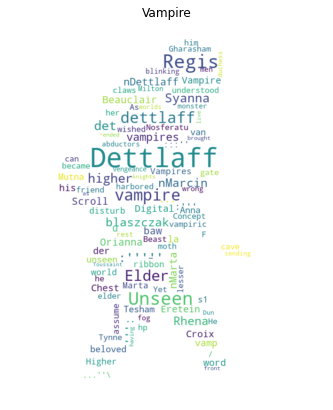

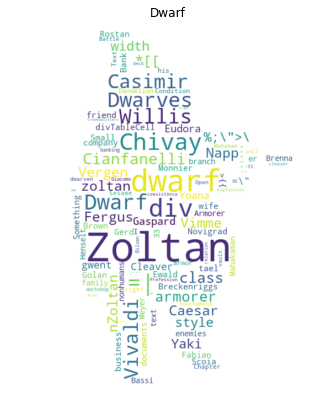

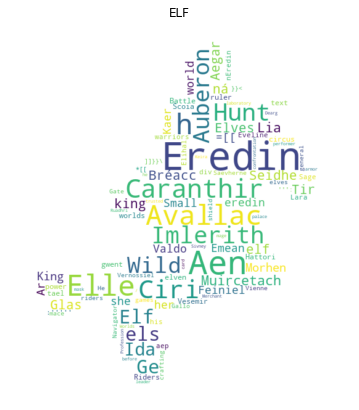

In [55]:
# Human
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('siri.png'))
word_tfidf_0 = pd.Series(tf_idfs[0], index=list(set(race_texts[0])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Human")
plt.show()

# Vampire
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Vampire.png'))
word_tfidf_0 = pd.Series(tf_idfs[1], index=list(set(race_texts[1])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Vampire")
plt.show()

# Dwarf
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Dwarf.png'))
word_tfidf_0 = pd.Series(tf_idfs[3], index=list(set(race_texts[3])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("Dwarf")
plt.show()

# Elf
plt.figure(figsize=(7, 7))
color_mask_Hylian= np.array(Image.open('Elf.png'))
word_tfidf_0 = pd.Series(tf_idfs[8], index=list(set(race_texts[8])))
wc_0 = WordCloud(mask=color_mask_Hylian,background_color="white", max_words=100, collocations = False).generate_from_frequencies(word_tfidf_0)
plt.imshow(wc_0, interpolation='bilinear')
plt.axis("off")
plt.title("ELF")
plt.show()

In [ ]:
# Based on Nation
file_list_all = [i+'.txt' for i in creatures]
df['file_name'] = file_list_all
file_list_n = []
for i in creatures: 
    if df[df['Name']==i].Nationality.isnull().bool():
        pass
    else:
        file_list_n.append(i+'.txt')

newDf_n = df.dropna(subset=['Nationality'])
        
corpus_root = 'creature_description'
filelists = nltk.corpus.PlaintextCorpusReader(corpus_root, file_list)

Nations = newDf_n['Nation'].unique()
nation_texts = []  

for n in Nations:
    file_nation = newDf_n[newDf_n['Nationality']==n].file_name
    n_corpus = nltk.corpus.PlaintextCorpusReader(corpus_root, file_nation)
    n_Text = nltk.Text(n_corpus.words())
    nation_texts.append(n_Text)
    
nation_tf = []; nation_words = []  

for i, n in enumerate(nation_texts):
    fdist = nltk.FreqDist(n)
    most_5 = fdist.most_common(5); words = [i[0] for i in most_5]
    tf = compute_tf(words, n)
    words_tf = list(zip(words, tf))
    nation_tf.append(words_tf)
    common_words.append(words)


nation_idf = []
for i in common_words: #words = [i[0] for i in most_5]
    idf = compute_idf(i, nation_texts)
    race_idf.append(idf)

tf_idfs = []
for r in nation_texts:
    words = set(r)
    tf = compute_tf(words, r)
    idf = compute_idf(words, nation_texts)
    tf_idf = tf * idf
    tf_idfs.append(tf_idf)

for i, t in enumerate(tf_idfs):
    index = np.argsort(t)[-5:]   
    content = list(set(nation_texts[i]))
    words = [content[n] for n in index]

In [63]:
df.head()

,Unnamed: 0,Name,Link,Race,Profession,Nationality,file_name
0,0.0,Adrien_de_Rouleau,"['Human', 'Bard', 'Toussaint', 'bard', 'Beaucl...",Human,Bard,Toussaintois,Adrien_de_Rouleau.txt
1,1.0,Agnetha_Skold,"['Human', 'Skelliger', 'gwent', 'the_Pheasantr...",Human,NaN,Skelliger,Agnetha_Skold.txt
2,2.0,Ambassador_von_Hinn,"['Human', 'Ambassador', 'Toussaint', 'Ambassad...",Human,Ambassador,Alban,Ambassador_von_Hinn.txt
3,3.0,Andrée_de_Bourbeau,"['Human', 'Jean-Christophe_de_Bourbeau', 'Jean...",Human,NaN,Toussaintois,Andrée_de_Bourbeau.txt
4,4.0,Anna_Henrietta,"['Duchess', 'Duchess', 'Toussaint', 'Human', '...",Human,NaN,Toussaintois,Anna_Henrietta.txt


## 3.2 Sentiment analysis


We choose NLTK for wiki anlysis and Textblob for dialog.
The main difference is that TextBlob is in fact built upon NLTK and Pattern. We believe that TextBlob provides for some extra functions than NLTK does, such 3 kinds of sentiment.

### 3.2.1 Wiki anlysis

In [20]:
G = nx.read_gpickle("graph_with_attributes.gpickle")
Gs = sorted(nx.connected_components(G), key=len, reverse=True)
Gcc = G.subgraph(Gs[0])

partition = community_louvain.best_partition(Gcc)
communities = list(set(partition.values())) 

In [130]:
len(communities)

22

In [21]:
community_names = []
for c in communities:
    sub_nodes = [k for k,v in partition.items() if v == c]
    sub_G = G.subgraph(sub_nodes)
    top_3 = [k for k, v in sorted(dict(sub_G.degree()).items(), key=lambda item: item[1], reverse=True)[:3]]
    name = ', '.join(top_3)
    community_names.append(name)

In [22]:
community_names

['Anna_Henrietta, Sylvia_Anna, Dettlaff_van_der_Eretein',
 'Bran_Tuirseach, Cerys_an_Craite, Crach_an_Craite',
 'Shaelmaar, The_Monster_of_Tufo, Andrée_de_Bourbeau',
 'Lambert, Jad_Karadin, Lund',
 'Armorer, Yoana, Fergus_Graem',
 'Dagmar, Allgod, Preben',
 'Silver_Basilisk, Auwry, Crinfrid_Reavers',
 'Crones, Phillip_Strenger, Anna_Strenger',
 'Ciri, Yennefer_of_Vengerberg, Triss_Merigold',
 'Grottore, Jacquette, François_le_Goff',
 'Bastien_Vildenvert, Dune_Vildenvert, Rhosyn',
 "Reginald_d'Aubry, Hughes_de_Saberre, Rolande_de_Flakfizer",
 "The_Witcher_3_merchants, Dulla_kh'Amanni, Little_Flint_Girl",
 "Olgierd_von_Everec, Gaunter_O'Dimm, Iris_von_Everec",
 'Carlo_Varese, Francis_Bedlam, Cyprian_Wiley',
 'Ulrich, Robbe, Tuur',
 'Geralt_of_Rivia, Ewald_Borsodi, Vimme_Vivaldi',
 'Priscilla, Hubert_Rejk, Patricia_Vegelbud',
 'Timmon, Mikkel_(Skelliger), Agda',
 'Herbalist, Tomira, Peter_Saar_Gwynleve',
 'Rosa_var_Attre, Henry_var_Attre, Lucas']

In [132]:
wnl = nltk.WordNetLemmatizer()
def get_tokens(string):
    tokens_tmp = WordPunctTokenizer().tokenize(string)
    words = [t.lower() for t in tokens_tmp if t.isalpha()]#(t.isalpha() and t.lower() not in stopwords.words('english'))
    tokens = [wnl.lemmatize(t) for t in words]
    return tokens

def calculate_sentiment(tokens):
    h_avgs = []
    for i, t in enumerate(tokens):
        if t in list(labmit_df['word']):
            idx = labmit_df[(labmit_df.word==t)].index[0]
            h_avg = labmit_df.loc[idx, 'happiness_average']
            h_avgs.append(h_avg)
    return np.mean(h_avgs)

In [25]:
word_list = pd.read_csv('labMIT-1.0.txt', sep='\t')

In [26]:
word_list.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [27]:
def sentiment(tokens):
    return pd.DataFrame(tokens, columns = ['word']).merge(word_list, on = 'word').happiness_average.mean()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xh975\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
# Make a function to tokenize a given text
def tokenize(text):
    text = word_tokenize(text)
    text = list(filter(lambda token: token not in string.punctuation, text)) # Remove punctuation
    text = [w.lower() for w in text]
    return text

In [43]:
path = './creature_description/'
file_path = os.listdir(path)

sent = []
witcher = []
text_tokens = []

for i in file_path:
    try:
        p = path + i
        f = open(p, encoding = "utf-8")
        raw_text = f.read()
        tokenized_text = tokenize(raw_text)
        women_dataframe = pd.DataFrame({'word': tokenized_text})
        women_dataframe.head()
        s = sentiment(women_dataframe)
        sent.append(s)
        witcher.append(i)
        text_tokens.append(tokenized_text)
    except:
        print('Encountered error')

In [45]:
wiki_sentiment = pd.DataFrame({'Name': witcher, 'Tokenized text': text_tokens, 'Sentiment': sent})
wiki_sentiment['Name'] = wiki_sentiment['Name'].map(lambda x: x.rstrip('.txt'))
wiki_sentiment['Name'] = wiki_sentiment['Name'].map(lambda x: x.replace('_', ' '))
wiki_sentiment.head()

,Name,Tokenized text,Sentiment
0,Aamad,"[``, spoilerbanner, \n, infobox, character\n|i...",5.271818
1,Abelard Rizza,"[``, disambigmsg|this, article, is, about, the...",5.537686
2,Abner de Navarette,"[``, infobox, character\n|image, hos, abner, d...",5.433500
3,Adela (Wild One),"[``, disambigmsg|this, article, is, about, the...",5.533939
4,Adrien de Rouleau,"[``, infobox, character\n|name, adrien, de, ro...",5.217925


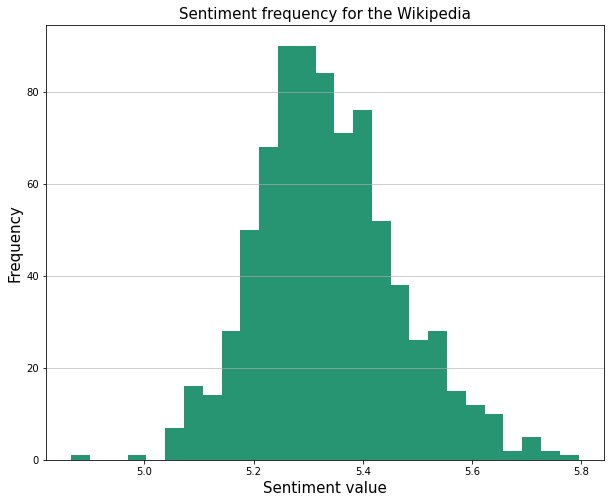

In [53]:
# Create a histogram of all  wik page sentiments
plt.figure(figsize = [10,8])
plt.hist(wiki_sentiment['Sentiment'], bins = 'auto', color = '#279472')
plt.grid(axis = 'y', alpha = 0.75)
plt.xlabel('Sentiment value', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Sentiment frequency for the Wikipedia', fontsize = 15)
plt.show()

In [54]:
wiki_sentiment[['Name', 'Sentiment']].nlargest(10, 'Sentiment').reset_index(drop = True)

,Name,Sentiment
0,Merchant (Blandare),5.795385
1,Merchant (Larvik),5.756667
2,Sven (Fayrlund),5.735714
3,Bea,5.723462
4,Hegel Grossbar,5.716000
5,Jesse Grossbar,5.716000
6,Manfred Grossbar,5.716000
7,Wine Merchant (Chuchote Cave),5.695714
8,Liesje,5.678621
9,Innkeep (Larvik),5.670588


In [56]:
wiki_sentiment[['Name', 'Sentiment']].nsmallest(10, 'Sentiment').reset_index(drop=True)

,Name,Sentiment
0,Prison Warden,4.866239
1,Dirk,4.970612
2,Yaren,5.044531
3,Shaelmaar from the Emperor of Nilfgaard,5.044565
4,Yorg's sister,5.055493
5,Titus Gielas,5.056739
6,John Verdun,5.057696
7,Arnout Vester,5.057953
8,Vernossiel,5.062119
9,Napp,5.080550


### 3.2.2 Dialog Analaysis

In [60]:
# Load Dataset

df = pd.read_csv('The_Witcher_Dialog.csv',encoding='utf-8')
df.head

<bound method NDFrame.head of      Character                                               Text
0      Isadora                                   What will it be?
1       Geralt                  Point me to the alderman's house.
2      Isadora                   It's down the alley to the left-
3     Inkeeper    Isadora! We don't want your kind here, Witcher.
4       Geralt  The alderman, tell me where he is and I'll be ...
...        ...                                                ...
1473      Ciri  You’ve been so kind to me, but Mousesack is al...
1474      Dara                        Are you sure about leaving?
1475      Ciri  I need answers. And I need you. You’re my fami...
1476    Eithne  The burden of power… can be painful. Be vigila...
1477      Ciri                    Thank you. For everything. Bye.

[1478 rows x 2 columns]>

In [61]:
# Remove Characters that don't fit to the top 15 characters in lines

removelst = df.Character.value_counts().iloc[15:].index.tolist()
for name in removelst:
    df = df[df['Character'] != name]

#### Which character has the most lines?

Text(0.5, 1.0, 'the Witcher: Character Line Count')

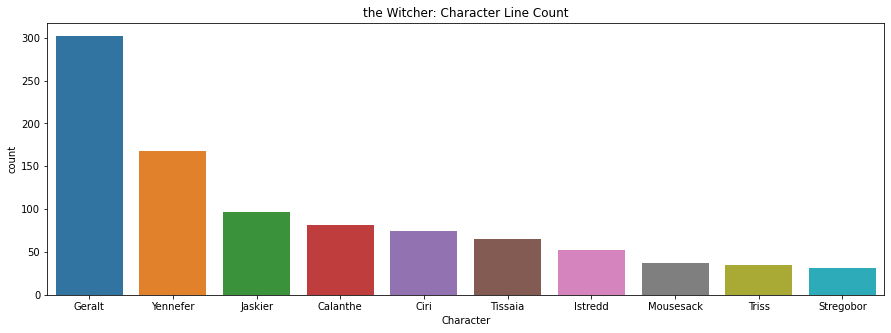

In [62]:
plt.figure(figsize=(15,5))
sns.countplot(x = 'Character', data = df, order = df.Character.value_counts().iloc[:10].index)
plt.title('the Witcher: Character Line Count')

#### Which character uses the most words on average?

Text(0.5, 1.0, 'the Witcher: Average Character Word Counts')

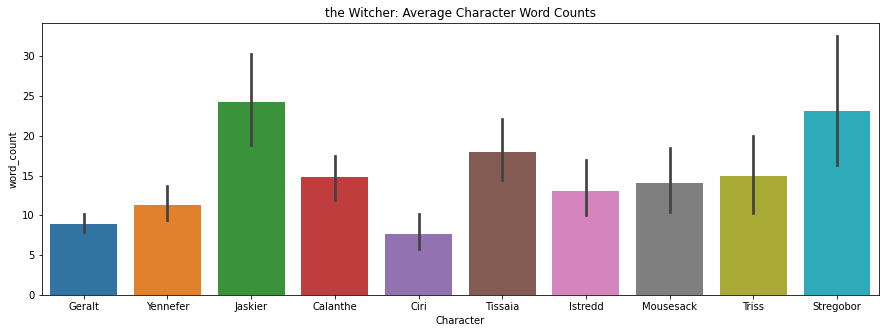

In [63]:
# Create Word Count Column

df['word_count'] = df['Text'].str.split().str.len()

plt.figure(figsize=(15,5))
sns.barplot(x='Character',y='word_count',data=df, order = df.Character.value_counts().iloc[:10].index)
plt.title('the Witcher: Average Character Word Counts')

In [64]:
# Clean and Normalize Text
# - tokenize
# - lowercase
# - remove punctuation
# - remove alphanumeric characters
# - remove stopwords

stopwords = set(stopwords.words('english'))

def clean(text):
    text = word_tokenize(text)
    text = [word.lower() for word in text]
    punct = str.maketrans('', '', string.punctuation) 
    text = [word.translate(punct) for word in text] 
    text = [word for word in text if word.isalpha()]
    text = [word for word in text if not word in stopwords]
    return " ".join(text)

df['clean_text'] = df['Text'].apply(clean)

In [65]:
df['clean_word_count'] = df['clean_text'].str.split().str.len()

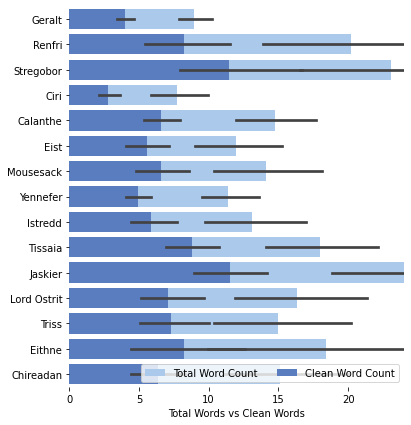

In [66]:
f, ax = plt.subplots(figsize=(6, 7))

sns.set_color_codes("pastel")
sns.barplot(x="word_count", y="Character", data=df,
            label="Total Word Count", color="b")

sns.set_color_codes("muted")
sns.barplot(x="clean_word_count", y="Character", data=df,
            label="Clean Word Count", color="b")

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Total Words vs Clean Words")
sns.despine(left=True, bottom=True)

In [67]:
df['polarity'] = [round(TextBlob(word).sentiment.polarity, 2) for word in df['clean_text']]
df['sentiment'] = ['positive' if polarity > 0 
                             else 'negative' if polarity < 0 
                                 else 'neutral' 
                                     for polarity in df['polarity']]

<AxesSubplot:ylabel='sentiment'>

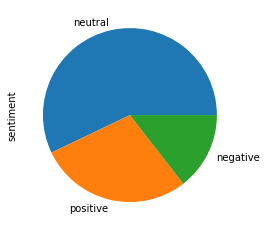

In [68]:
# Sentiment
df.sentiment.value_counts().plot(kind='pie')

Text(0.5, 1.0, 'the Witcher: Character Clean Text Sentiment')

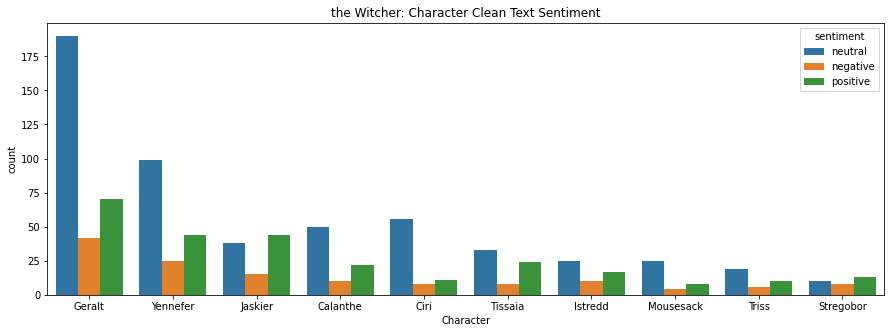

In [69]:
plt.figure(figsize=(15,5))
sns.countplot(x='Character',hue='sentiment',data=df,order=df.Character.value_counts().iloc[:10].index)
plt.title('the Witcher: Character Clean Text Sentiment')

# 4 Discussion

**What went well?**
   
- The data extractation went well. The experience from the course helped a lot, which saved a lot of time, since several code cells from the assignments only needed to be adjusted to the project. Additionally, the size of the network turned out to be much bigger than originally expected. The topic was interesting and the webpage configuration was more fun than expected. The project made it possible for the group to be creative in visualization and it was easy to dig deeper when time allowed. Network visualizations and word clouds came out nicely.

**What is still missing? What could be improved? Why?**

- The data clean up could have gone much further if time would have allowed. Additionally, we hope to analyze the relations between countries, regions and affliations, but it turns out that the wikipedia dosen't fit for this task. It missing too many details.
<br>
- It would have been interesting to look more into dialog as well. The dialog data only included TV series but we actually expect it form games,which is believed to have had resulted in more variance for the sentiment analysis of the data. We also did not include the players comments and feedback for the gmae.